In [1]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices[1:],'GPU')

tf.executing_eagerly()
print(tf.executing_eagerly())

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import math
import random
import time
import functools

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import datasets, Input, layers, models, Model, losses
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM
from IPython import display
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

True


In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
for gpu_instance in physical_devices: 
    tf.config.experimental.set_memory_growth(gpu_instance, True)

tf.device('/GPU:1')
tf.config.experimental.list_physical_devices('GPU')

#strategy = tf.distribute.MirroredStrategy()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

# Input data stream

In [3]:
input_params = data = pd.read_table('input_data/condition.txt', header = None)

datasetNo = int(input_params.values[5,2])
n_epochs = int(input_params.values[10,2])
batch_size = int(input_params.values[11,2])
LR =float(input_params.values[12,2])
Lv1_latent_dim = int(input_params.values[13,2])
stride1 = int(input_params.values[14,2])
stride2 = int(input_params.values[15,2])
stride3 = int(input_params.values[16,2])
C1 = int(input_params.values[17,2])
C2 = int(input_params.values[18,2])
C3 = int(input_params.values[19,2])
C4 = int(input_params.values[20,2])
C5 = int(input_params.values[21,2])
alpha = int(input_params.values[22,2])

num_param = int(input_params.values[1,2])
num_time = int(input_params.values[2,2])
num_time_to = int(input_params.values[27,2])
num_node = int(input_params.values[3,2])
num_var = int(input_params.values[4,2])

epoch_read = int(input_params.values[25,2])
epoch_latent = int(input_params.values[26,2])

interp_lower = int(input_params.values[6,2])
interp_upper = int(input_params.values[7,2])

print('num_param : ', num_param)
print('num_time : ', num_time)
print('num_node : ', num_node)
print('num_var : ', num_var)
print(' ')
print('datasetNo : ', datasetNo)
print('Lv1_epochs : ', n_epochs)
print('Lv1_batch_size : ', batch_size)
print('Lv1_LearningRate : ', LR)
print('Lv1_latent_dim : ', Lv1_latent_dim)

num_param :  10
num_time :  800
num_node :  100
num_var :  1
 
datasetNo :  1
Lv1_epochs :  50000
Lv1_batch_size :  1
Lv1_LearningRate :  2e-05
Lv1_latent_dim :  256


In [4]:
data_save = np.zeros((num_var, num_node,num_param*num_time))
data = np.zeros((num_node,num_param*num_time))

if datasetNo == 1:
    data = pd.read_csv('input_data/FOM_u_sorted.csv', header = None)
    print(data.shape)
    #print(data)
    data_save[0,0:num_node,:]=data.values[0:num_node,:]

if datasetNo == 2:
    del(data)
    data = pd.read_csv('input_data/FOM_v_sorted.csv', header = None)
    print(data.shape)
    data_save[0,0:num_node,:]=data.values[0:num_node,:]

if datasetNo == 3:
    del(data)
    data = pd.read_csv('input_data/FOM_x_sorted.csv', header = None)
    print(data.shape)
    data_save[0,0:num_node,:]=data.values[0:num_node,:]

if datasetNo == 4:
    del(data)
    data = pd.read_csv('input_data/FOM_y_sorted.csv', header = None)
    print(data.shape)
    data_save[0,0:num_node,:]=data.values[0:num_node,:]
    del(data)


# Data_save shape : (num_var, num_node, num_time x num_param)

print(data_save.shape)
print(len(np.transpose(data_save)))

data=data_save

(14300, 8000)
(1, 100, 8000)
8000


In [5]:
# validate
data.shape

(1, 100, 8000)

## FOM data type : FOM_data = np.array[param, time, node, var]

In [6]:
FOM_data = np.zeros((num_param, num_time, num_node))

for i in range(num_var):
    for j in range(num_node):
        for k in range(num_param):
            for l in range(num_time):
                temp = l+k*num_time
                #print(l, k, temp)
                FOM_data[k,l,j]=data[i,j,temp]
                
FOM_data.shape

FOM_data_temp = np.zeros((num_param, num_time, num_node))
FOM_data_temp = FOM_data
del FOM_data
num_time = num_time_to
FOM_data = np.zeros((num_param, num_time, num_node))

FOM_data[:,0:num_time,:] = FOM_data_temp[:,0:num_time,:]
del FOM_data_temp

#del data

In [7]:
x_axis = np.linspace(0,num_node,num_node)

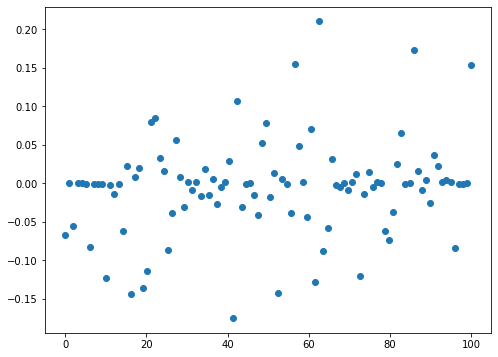

In [8]:
plt.scatter(x_axis, FOM_data[0,0,:])

In [9]:
maximum = np.amax(FOM_data)
minimum = np.amin(FOM_data)
mean = np.mean(FOM_data)
AT = maximum-minimum

print(maximum)
print(minimum)
print(mean)
print(AT)

1.8047008785
-2.14637945807875
1.4742518317234498e-15
3.95108033657875


In [10]:
FOM_data = FOM_data-mean
FOM_data = FOM_data/AT
min_FOM = np.min(FOM_data)
FOM_data = FOM_data-min_FOM

print(np.max(FOM_data))
print(np.min(FOM_data))

1.0
0.0


In [11]:
print(np.max(FOM_data))
print(np.min(FOM_data))

1.0
0.0


In [12]:
FOM_data.shape

(10, 800, 100)

# Level 1, SVAE (spatial VAE)

In [13]:
#Lv1_input = np.zeros((num_param*num_time, num_node, num_var))
# Lv1_input = (num_param x num_time, num_node, num_var)

Lv1_input = FOM_data.reshape(-1, num_node)
Lv1_input.shape
# Lv1_input is elongated w.r.t. param, 1,2,3,4,..../param change/1,2,3,4,.....

(8000, 100)

In [14]:
#validate

#Lv1_input[200,0,0]
Lv1_input_shape_decoder = Lv1_input.shape[1]

In [15]:
Lv1_input_shape = Lv1_input.shape[1:]

In [16]:
print(Lv1_input.shape)
print(Lv1_input_shape)

(8000, 100)
(100,)


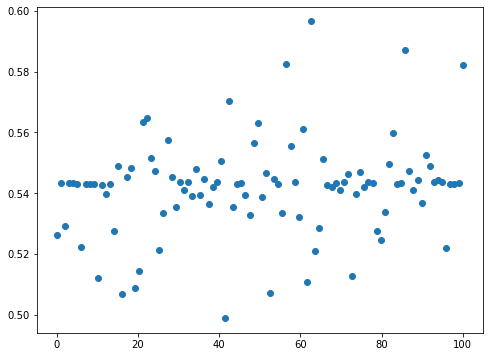

In [17]:
plt.scatter(x_axis, Lv1_input[0,:])

# Acquire latent vectors

In [18]:
# acquire latent vectors for each param and time sets.
# Lv1_input is elongated w.r.t. param, 1,2,3,4,..../param change/1,2,3,4,.....

#del Encoder
#del Decoder

filename1='Lv1_networks/encoder_%d.h5' % (epoch_read)
filename2 = 'Lv1_networks/decoder_%d.h5' % (epoch_read)
Encoder = load_model(filename1)
Encoder.summary()
Decoder = load_model(filename2)
Decoder.summary()

Model: "ENCODER"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 800, 100)]   0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 800, 1024)    513024      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 800, 1024)    0           conv1d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 800, 1024)    0           leaky_re_lu[0][0]                
____________________________________________________________________________________________

Model: "DECODER"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 819200)       210534400   input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_11 (LeakyReLU)      (None, 819200)       0           dense_2[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 800, 1024)    0           leaky_re_lu_11[0][0]             
____________________________________________________________________________________________

In [19]:
n_epochs_latent = epoch_latent

In [20]:
FOM_data.shape

(10, 800, 100)

In [21]:
Lv1_input = FOM_data

In [22]:
latent_vector_save=np.zeros([num_param, Lv1_latent_dim])

def reparam(mu,var):
    
    eps = tf.random.normal(shape=[Lv1_latent_dim], mean=0.0, stddev=1.0)
    z = eps * tf.math.sqrt(var) + mu
    
    return z

def find_latent(x_train):
    
    mu, var,latent_temp = Encoder(x_train, training=False)
    latent_vector = reparam(mu[-1], var[-1])
    latent_vector = np.reshape(latent_vector, [-1, Lv1_latent_dim])
    gen_x, _ = Decoder(latent_vector, training=False)
    
    return latent_vector, gen_x

latent_vectors = np.zeros([num_param, Lv1_latent_dim])
latent_vector = np.zeros([1, Lv1_latent_dim])
loss_save = np.ones([num_param])*1000

for i in range(epoch_latent): 
    for j in range(num_param):
        x = FOM_data[j, :,:]
        x = np.reshape(x,(1,x.shape[0],x.shape[1]))
        
        latent_vector, gen_x = find_latent(x)
        
        loss = tf.math.reduce_mean(tf.math.square(x - gen_x))
        
        if loss < loss_save[j]:
            loss_save[j] = loss
            latent_vector_save[j] = latent_vector
            
    del latent_vector
    print('Epoch: {}'.format(i))
    print(loss_save)

Epoch: 0
[5.68366340e-06 1.66504979e-04 1.76715388e-04 4.73996297e-05
 2.53049424e-04 7.22492288e-04 1.11861540e-04 1.78867573e-04
 7.80853152e-04 2.46100081e-03]
Epoch: 1
[5.68366340e-06 1.66504979e-04 1.66466358e-04 4.73996297e-05
 3.73314942e-05 3.87676526e-04 1.11861540e-04 1.78867573e-04
 5.02993935e-04 3.17486381e-04]
Epoch: 2
[5.11513417e-06 1.66504979e-04 1.66466358e-04 4.73996297e-05
 3.73314942e-05 3.87676526e-04 1.11861540e-04 1.57271585e-04
 3.27062007e-04 3.17486381e-04]
Epoch: 3
[5.11513417e-06 1.37687202e-05 2.16318258e-05 4.23024030e-05
 3.73314942e-05 3.87676526e-04 1.11861540e-04 1.57271585e-04
 3.27062007e-04 3.17486381e-04]
Epoch: 4
[5.11513417e-06 1.37687202e-05 2.16318258e-05 4.23024030e-05
 3.73314942e-05 3.87676526e-04 8.48409982e-05 1.57271585e-04
 2.13510997e-04 3.17486381e-04]
Epoch: 5
[5.11513417e-06 1.37687202e-05 2.16318258e-05 4.23024030e-05
 3.73314942e-05 5.33126222e-05 8.48409982e-05 1.57271585e-04
 2.13510997e-04 3.17486381e-04]
Epoch: 6
[5.11513417e-

Epoch: 51
[5.00862097e-06 1.02988615e-05 1.87334754e-05 4.23024030e-05
 3.48070025e-05 5.25700198e-05 8.17850378e-05 1.52011940e-04
 2.03311021e-04 3.04915680e-04]
Epoch: 52
[5.00862097e-06 1.02988615e-05 1.87334754e-05 4.23024030e-05
 3.48070025e-05 5.25700198e-05 8.17850378e-05 1.52011940e-04
 2.03311021e-04 3.04915680e-04]
Epoch: 53
[5.00862097e-06 1.02988615e-05 1.87334754e-05 4.23024030e-05
 3.48070025e-05 5.25700198e-05 8.17850378e-05 1.52011940e-04
 2.03311021e-04 3.04915680e-04]
Epoch: 54
[5.00862097e-06 1.02988615e-05 1.87334754e-05 4.23024030e-05
 3.48070025e-05 5.25700198e-05 8.17850378e-05 1.52011940e-04
 2.03311021e-04 3.04915680e-04]
Epoch: 55
[5.00862097e-06 1.02988615e-05 1.87334754e-05 4.23024030e-05
 3.48070025e-05 5.25700198e-05 8.17850378e-05 1.52011940e-04
 2.03311021e-04 3.04915680e-04]
Epoch: 56
[5.00862097e-06 1.02988615e-05 1.87334754e-05 4.23024030e-05
 3.48070025e-05 5.25700198e-05 8.17850378e-05 1.52011940e-04
 2.03311021e-04 3.04915680e-04]
Epoch: 57
[5.008

Epoch: 101
[4.86175441e-06 1.01583555e-05 1.87334754e-05 4.23024030e-05
 3.48070025e-05 5.25700198e-05 7.99049376e-05 1.52011940e-04
 2.03311021e-04 3.04915680e-04]
Epoch: 102
[4.86175441e-06 1.01583555e-05 1.87334754e-05 4.23024030e-05
 3.48070025e-05 5.25700198e-05 7.99049376e-05 1.52011940e-04
 2.03311021e-04 3.04915680e-04]
Epoch: 103
[4.86175441e-06 1.01583555e-05 1.87334754e-05 4.23024030e-05
 3.48070025e-05 5.25700198e-05 7.99049376e-05 1.52011940e-04
 2.03311021e-04 3.04915680e-04]
Epoch: 104
[4.86175441e-06 1.01583555e-05 1.87334754e-05 4.23024030e-05
 3.48070025e-05 5.25700198e-05 7.99049376e-05 1.52011940e-04
 2.03311021e-04 3.04915680e-04]
Epoch: 105
[4.86175441e-06 1.01583555e-05 1.87334754e-05 4.23024030e-05
 3.48070025e-05 5.25700198e-05 7.99049376e-05 1.52011940e-04
 2.03311021e-04 3.04915680e-04]
Epoch: 106
[4.86175441e-06 1.01583555e-05 1.87334754e-05 4.23024030e-05
 3.48070025e-05 5.25700198e-05 7.99049376e-05 1.52011940e-04
 2.03311021e-04 3.04915680e-04]
Epoch: 107

Epoch: 151
[4.86175441e-06 1.01583555e-05 1.87334754e-05 4.12080226e-05
 3.48070025e-05 5.15535903e-05 7.99049376e-05 1.52011940e-04
 2.03311021e-04 3.04915680e-04]
Epoch: 152
[4.86175441e-06 1.01583555e-05 1.87334754e-05 4.12080226e-05
 3.48070025e-05 5.15535903e-05 7.99049376e-05 1.52011940e-04
 2.03311021e-04 3.04915680e-04]
Epoch: 153
[4.86175441e-06 1.01583555e-05 1.87334754e-05 4.12080226e-05
 3.48070025e-05 5.15535903e-05 7.99049376e-05 1.52011940e-04
 2.03311021e-04 3.04915680e-04]
Epoch: 154
[4.86175441e-06 1.01583555e-05 1.87334754e-05 4.12080226e-05
 3.48070025e-05 5.15535903e-05 7.99049376e-05 1.52011940e-04
 2.03311021e-04 3.04915680e-04]
Epoch: 155
[4.86175441e-06 1.01583555e-05 1.87334754e-05 4.12080226e-05
 3.48070025e-05 5.15535903e-05 7.99049376e-05 1.52011940e-04
 2.03311021e-04 3.04915680e-04]
Epoch: 156
[4.86175441e-06 1.01583555e-05 1.87334754e-05 4.12080226e-05
 3.48070025e-05 5.15535903e-05 7.99049376e-05 1.52011940e-04
 2.03311021e-04 3.04915680e-04]
Epoch: 157

Epoch: 201
[4.86175441e-06 1.01583555e-05 1.87334754e-05 4.12080226e-05
 3.48070025e-05 5.15535903e-05 7.99049376e-05 1.52011940e-04
 2.03311021e-04 3.04915680e-04]
Epoch: 202
[4.86175441e-06 1.01583555e-05 1.87334754e-05 4.12080226e-05
 3.48070025e-05 5.15535903e-05 7.99049376e-05 1.52011940e-04
 2.03311021e-04 3.04915680e-04]
Epoch: 203
[4.86175441e-06 1.01583555e-05 1.87334754e-05 4.12080226e-05
 3.48070025e-05 5.15535903e-05 7.99049376e-05 1.52011940e-04
 2.03311021e-04 3.04915680e-04]
Epoch: 204
[4.86175441e-06 1.01583555e-05 1.87334754e-05 4.12080226e-05
 3.48070025e-05 5.15535903e-05 7.99049376e-05 1.52011940e-04
 2.03311021e-04 3.04915680e-04]
Epoch: 205
[4.86175441e-06 1.01583555e-05 1.87334754e-05 4.12080226e-05
 3.48070025e-05 5.15535903e-05 7.99049376e-05 1.52011940e-04
 2.03311021e-04 3.04915680e-04]
Epoch: 206
[4.86175441e-06 1.01583555e-05 1.87334754e-05 4.12080226e-05
 3.48070025e-05 5.15535903e-05 7.99049376e-05 1.47289931e-04
 2.03311021e-04 3.04915680e-04]
Epoch: 207

Epoch: 251
[4.86175441e-06 1.00018606e-05 1.87334754e-05 4.12080226e-05
 3.48070025e-05 5.13233790e-05 7.99049376e-05 1.47289931e-04
 2.03311021e-04 3.04915680e-04]
Epoch: 252
[4.86175441e-06 1.00018606e-05 1.87334754e-05 4.12080226e-05
 3.48070025e-05 5.13233790e-05 7.99049376e-05 1.47289931e-04
 2.03311021e-04 3.04915680e-04]
Epoch: 253
[4.86175441e-06 1.00018606e-05 1.87334754e-05 4.12080226e-05
 3.48070025e-05 5.13233790e-05 7.99049376e-05 1.47289931e-04
 2.03311021e-04 3.04915680e-04]
Epoch: 254
[4.86175441e-06 1.00018606e-05 1.87334754e-05 4.12080226e-05
 3.48070025e-05 5.13233790e-05 7.99049376e-05 1.47289931e-04
 2.03311021e-04 3.04915680e-04]
Epoch: 255
[4.86175441e-06 1.00018606e-05 1.87334754e-05 4.12080226e-05
 3.48070025e-05 5.13233790e-05 7.99049376e-05 1.47289931e-04
 2.03311021e-04 3.04915680e-04]
Epoch: 256
[4.65526864e-06 1.00018606e-05 1.87334754e-05 4.12080226e-05
 3.48070025e-05 5.13233790e-05 7.99049376e-05 1.47289931e-04
 2.03311021e-04 3.04915680e-04]
Epoch: 257

Epoch: 301
[4.65526864e-06 1.00018606e-05 1.87334754e-05 4.12080226e-05
 3.48070025e-05 5.13233790e-05 7.99049376e-05 1.47289931e-04
 2.03311021e-04 3.04915680e-04]
Epoch: 302
[4.65526864e-06 1.00018606e-05 1.87334754e-05 4.12080226e-05
 3.48070025e-05 5.13233790e-05 7.99049376e-05 1.47289931e-04
 2.03311021e-04 3.04915680e-04]
Epoch: 303
[4.65526864e-06 1.00018606e-05 1.87334754e-05 4.12080226e-05
 3.48070025e-05 5.13233790e-05 7.99049376e-05 1.47289931e-04
 2.03311021e-04 3.04915680e-04]
Epoch: 304
[4.65526864e-06 1.00018606e-05 1.87334754e-05 4.12080226e-05
 3.48070025e-05 5.13233790e-05 7.99049376e-05 1.47289931e-04
 2.03311021e-04 3.04915680e-04]
Epoch: 305
[4.65526864e-06 1.00018606e-05 1.87334754e-05 4.12080226e-05
 3.48070025e-05 5.13233790e-05 7.99049376e-05 1.47289931e-04
 2.03311021e-04 3.04915680e-04]
Epoch: 306
[4.65526864e-06 1.00018606e-05 1.87334754e-05 4.12080226e-05
 3.48070025e-05 5.13233790e-05 7.99049376e-05 1.47289931e-04
 2.03311021e-04 3.04915680e-04]
Epoch: 307

Epoch: 351
[4.65526864e-06 1.00018606e-05 1.87334754e-05 4.12080226e-05
 3.48070025e-05 5.13233790e-05 7.99049376e-05 1.47289931e-04
 2.03311021e-04 3.04915680e-04]
Epoch: 352
[4.65526864e-06 1.00018606e-05 1.87334754e-05 4.12080226e-05
 3.48070025e-05 5.13233790e-05 7.99049376e-05 1.47289931e-04
 2.03311021e-04 3.04915680e-04]
Epoch: 353
[4.65526864e-06 1.00018606e-05 1.87334754e-05 4.12080226e-05
 3.48070025e-05 5.13233790e-05 7.99049376e-05 1.47289931e-04
 2.03311021e-04 3.04915680e-04]
Epoch: 354
[4.65526864e-06 1.00018606e-05 1.87334754e-05 4.12080226e-05
 3.48070025e-05 5.13233790e-05 7.99049376e-05 1.47289931e-04
 2.03311021e-04 3.04915680e-04]
Epoch: 355
[4.65526864e-06 1.00018606e-05 1.87334754e-05 4.12080226e-05
 3.48070025e-05 5.13233790e-05 7.99049376e-05 1.47289931e-04
 2.03311021e-04 3.04915680e-04]
Epoch: 356
[4.65526864e-06 1.00018606e-05 1.87334754e-05 4.12080226e-05
 3.48070025e-05 5.13233790e-05 7.99049376e-05 1.47289931e-04
 2.03311021e-04 3.04915680e-04]
Epoch: 357

Epoch: 401
[4.65526864e-06 1.00018606e-05 1.87334754e-05 4.12080226e-05
 3.48070025e-05 5.13233790e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04915680e-04]
Epoch: 402
[4.65526864e-06 1.00018606e-05 1.87334754e-05 4.12080226e-05
 3.48070025e-05 5.13233790e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04915680e-04]
Epoch: 403
[4.65526864e-06 1.00018606e-05 1.87334754e-05 4.12080226e-05
 3.48070025e-05 5.13233790e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04915680e-04]
Epoch: 404
[4.65526864e-06 1.00018606e-05 1.87334754e-05 4.12080226e-05
 3.48070025e-05 5.13233790e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04915680e-04]
Epoch: 405
[4.65526864e-06 1.00018606e-05 1.87334754e-05 4.12080226e-05
 3.48070025e-05 5.13233790e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04915680e-04]
Epoch: 406
[4.65526864e-06 1.00018606e-05 1.87334754e-05 4.12080226e-05
 3.48070025e-05 5.13233790e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04915680e-04]
Epoch: 407

Epoch: 451
[4.65526864e-06 1.00018606e-05 1.87334754e-05 4.12080226e-05
 3.48070025e-05 5.13233790e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04915680e-04]
Epoch: 452
[4.65526864e-06 1.00018606e-05 1.87334754e-05 4.12080226e-05
 3.48070025e-05 5.13233790e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04915680e-04]
Epoch: 453
[4.65526864e-06 1.00018606e-05 1.87334754e-05 4.12080226e-05
 3.48070025e-05 5.13233790e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04915680e-04]
Epoch: 454
[4.65526864e-06 1.00018606e-05 1.87334754e-05 4.12080226e-05
 3.48070025e-05 5.13233790e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04915680e-04]
Epoch: 455
[4.65526864e-06 1.00018606e-05 1.87334754e-05 4.12080226e-05
 3.48070025e-05 5.13233790e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04915680e-04]
Epoch: 456
[4.65526864e-06 1.00018606e-05 1.87334754e-05 4.12080226e-05
 3.48070025e-05 5.13233790e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04915680e-04]
Epoch: 457

Epoch: 501
[4.65526864e-06 1.00018606e-05 1.87334754e-05 4.04834573e-05
 3.48070025e-05 5.13233790e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04915680e-04]
Epoch: 502
[4.65526864e-06 1.00018606e-05 1.87334754e-05 4.04834573e-05
 3.48070025e-05 5.13233790e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04915680e-04]
Epoch: 503
[4.65526864e-06 1.00018606e-05 1.87334754e-05 4.04834573e-05
 3.48070025e-05 5.13233790e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04915680e-04]
Epoch: 504
[4.65526864e-06 1.00018606e-05 1.87334754e-05 4.04834573e-05
 3.48070025e-05 5.13233790e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04915680e-04]
Epoch: 505
[4.65526864e-06 1.00018606e-05 1.87334754e-05 4.04834573e-05
 3.48070025e-05 5.13233790e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04915680e-04]
Epoch: 506
[4.65526864e-06 1.00018606e-05 1.87334754e-05 4.04834573e-05
 3.48070025e-05 5.13233790e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04915680e-04]
Epoch: 507

Epoch: 551
[4.65526864e-06 1.00018606e-05 1.87334754e-05 4.04834573e-05
 3.48070025e-05 5.13233790e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04197776e-04]
Epoch: 552
[4.65526864e-06 1.00018606e-05 1.87334754e-05 4.04834573e-05
 3.48070025e-05 5.13233790e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04197776e-04]
Epoch: 553
[4.65526864e-06 1.00018606e-05 1.87334754e-05 4.04834573e-05
 3.48070025e-05 5.13233790e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04197776e-04]
Epoch: 554
[4.65526864e-06 1.00018606e-05 1.87334754e-05 4.04834573e-05
 3.48070025e-05 5.13233790e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04197776e-04]
Epoch: 555
[4.65526864e-06 1.00018606e-05 1.87334754e-05 4.04834573e-05
 3.48070025e-05 5.13233790e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04197776e-04]
Epoch: 556
[4.65526864e-06 1.00018606e-05 1.87334754e-05 4.04834573e-05
 3.48070025e-05 5.13233790e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04197776e-04]
Epoch: 557

Epoch: 601
[4.65526864e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.48070025e-05 5.01890972e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04197776e-04]
Epoch: 602
[4.65526864e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.48070025e-05 5.01890972e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04197776e-04]
Epoch: 603
[4.65526864e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.48070025e-05 5.01890972e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04197776e-04]
Epoch: 604
[4.65526864e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.48070025e-05 5.01890972e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04197776e-04]
Epoch: 605
[4.65526864e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.48070025e-05 5.01890972e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04197776e-04]
Epoch: 606
[4.65526864e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.48070025e-05 5.01890972e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04197776e-04]
Epoch: 607

Epoch: 651
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.48070025e-05 5.01890972e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04197776e-04]
Epoch: 652
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.48070025e-05 5.01890972e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04197776e-04]
Epoch: 653
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.48070025e-05 5.01890972e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04197776e-04]
Epoch: 654
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.48070025e-05 5.01890972e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04197776e-04]
Epoch: 655
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.48070025e-05 5.01890972e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04197776e-04]
Epoch: 656
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.48070025e-05 5.01890972e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04197776e-04]
Epoch: 657

Epoch: 701
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.48070025e-05 5.01890972e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04197776e-04]
Epoch: 702
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.48070025e-05 5.01890972e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04197776e-04]
Epoch: 703
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.48070025e-05 5.01890972e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04197776e-04]
Epoch: 704
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.48070025e-05 5.01890972e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04197776e-04]
Epoch: 705
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.48070025e-05 5.01890972e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04197776e-04]
Epoch: 706
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.48070025e-05 5.01890972e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04197776e-04]
Epoch: 707

Epoch: 751
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.48070025e-05 5.01890972e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04197776e-04]
Epoch: 752
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.48070025e-05 5.01890972e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04197776e-04]
Epoch: 753
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.48070025e-05 5.01890972e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04197776e-04]
Epoch: 754
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.48070025e-05 5.01890972e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04197776e-04]
Epoch: 755
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.48070025e-05 5.01890972e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04197776e-04]
Epoch: 756
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.48070025e-05 5.01890972e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04197776e-04]
Epoch: 757

Epoch: 801
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.48070025e-05 5.01890972e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04197776e-04]
Epoch: 802
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.48070025e-05 5.01890972e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04197776e-04]
Epoch: 803
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.48070025e-05 5.01890972e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04197776e-04]
Epoch: 804
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.48070025e-05 5.01890972e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04197776e-04]
Epoch: 805
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.48070025e-05 5.01890972e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04197776e-04]
Epoch: 806
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.45451226e-05 5.01890972e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04197776e-04]
Epoch: 807

Epoch: 851
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.45451226e-05 5.01890972e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.04197776e-04]
Epoch: 852
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.45451226e-05 5.01890972e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 853
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.45451226e-05 5.01890972e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 854
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.45451226e-05 5.01890972e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 855
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.45451226e-05 5.01890972e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 856
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.45451226e-05 5.01890972e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 857

Epoch: 901
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 902
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 903
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 904
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 905
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 906
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 907

Epoch: 951
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 952
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 953
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 954
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 955
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 956
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 957

Epoch: 1001
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1002
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1003
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1004
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1005
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1006
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoc

Epoch: 1051
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1052
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1053
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1054
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1055
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1056
[4.62285288e-06 9.79444849e-06 1.87334754e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoc

Epoch: 1101
[4.62285288e-06 9.79444849e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1102
[4.62285288e-06 9.79444849e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1103
[4.62285288e-06 9.79444849e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1104
[4.62285288e-06 9.79444849e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1105
[4.62285288e-06 9.79444849e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1106
[4.62285288e-06 9.79444849e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoc

Epoch: 1151
[4.62285288e-06 9.79444849e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1152
[4.62285288e-06 9.79444849e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1153
[4.62285288e-06 9.79444849e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1154
[4.62285288e-06 9.79444849e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1155
[4.62285288e-06 9.79444849e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1156
[4.62285288e-06 9.79444849e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoc

Epoch: 1201
[4.62285288e-06 9.79444849e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1202
[4.62285288e-06 9.79444849e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1203
[4.62285288e-06 9.79444849e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1204
[4.62285288e-06 9.79444849e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1205
[4.62285288e-06 9.79444849e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1206
[4.62285288e-06 9.79444849e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoc

Epoch: 1251
[4.62285288e-06 9.79444849e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1252
[4.62285288e-06 9.79444849e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1253
[4.62285288e-06 9.79444849e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1254
[4.62285288e-06 9.79444849e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1255
[4.62285288e-06 9.79444849e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1256
[4.62285288e-06 9.79444849e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoc

Epoch: 1301
[4.62285288e-06 9.75020248e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1302
[4.62285288e-06 9.75020248e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1303
[4.62285288e-06 9.75020248e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1304
[4.62285288e-06 9.75020248e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1305
[4.62285288e-06 9.75020248e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1306
[4.62285288e-06 9.75020248e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoc

Epoch: 1351
[4.62285288e-06 9.75020248e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1352
[4.62285288e-06 9.75020248e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1353
[4.62285288e-06 9.75020248e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1354
[4.62285288e-06 9.75020248e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1355
[4.62285288e-06 9.75020248e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1356
[4.62285288e-06 9.75020248e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoc

Epoch: 1401
[4.62285288e-06 9.75020248e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1402
[4.62285288e-06 9.75020248e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1403
[4.62285288e-06 9.75020248e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1404
[4.62285288e-06 9.75020248e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1405
[4.62285288e-06 9.75020248e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1406
[4.62285288e-06 9.75020248e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 5.01512768e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoc

Epoch: 1451
[4.62285288e-06 9.75020248e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1452
[4.62285288e-06 9.75020248e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1453
[4.62285288e-06 9.75020248e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1454
[4.62285288e-06 9.75020248e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1455
[4.62285288e-06 9.75020248e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1456
[4.62285288e-06 9.75020248e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoc

Epoch: 1501
[4.62285288e-06 9.75020248e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1502
[4.62285288e-06 9.75020248e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1503
[4.62285288e-06 9.75020248e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1504
[4.62285288e-06 9.75020248e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1505
[4.62285288e-06 9.75020248e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1506
[4.62285288e-06 9.75020248e-06 1.86139969e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoc

Epoch: 1551
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1552
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1553
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1554
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1555
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1556
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoc

Epoch: 1601
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1602
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1603
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1604
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1605
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1606
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoc

Epoch: 1651
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1652
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1653
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1654
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1655
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1656
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoc

Epoch: 1701
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1702
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1703
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1704
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1705
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1706
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoc

Epoch: 1751
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1752
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1753
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1754
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1755
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.47289931e-04
 2.03171163e-04 3.01684719e-04]
Epoch: 1756
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.46997903e-04
 2.03171163e-04 3.01684719e-04]
Epoc

Epoch: 1801
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.46997903e-04
 2.01347109e-04 3.01684719e-04]
Epoch: 1802
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.46997903e-04
 2.01347109e-04 3.01684719e-04]
Epoch: 1803
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.46997903e-04
 2.01347109e-04 3.01684719e-04]
Epoch: 1804
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.46997903e-04
 2.01347109e-04 3.01684719e-04]
Epoch: 1805
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.46997903e-04
 2.01347109e-04 3.01684719e-04]
Epoch: 1806
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.46997903e-04
 2.01347109e-04 3.01684719e-04]
Epoc

Epoch: 1851
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.46997903e-04
 2.01347109e-04 3.01684719e-04]
Epoch: 1852
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.46997903e-04
 2.01347109e-04 3.01684719e-04]
Epoch: 1853
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.46997903e-04
 2.01347109e-04 3.01684719e-04]
Epoch: 1854
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.46997903e-04
 2.01347109e-04 3.01684719e-04]
Epoch: 1855
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.46997903e-04
 2.01347109e-04 3.01684719e-04]
Epoch: 1856
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.46997903e-04
 2.01347109e-04 3.01684719e-04]
Epoc

Epoch: 1901
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.46997903e-04
 2.01347109e-04 3.01684719e-04]
Epoch: 1902
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.46997903e-04
 2.01347109e-04 3.01684719e-04]
Epoch: 1903
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.46997903e-04
 2.01347109e-04 3.01684719e-04]
Epoch: 1904
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.46997903e-04
 2.01347109e-04 3.01684719e-04]
Epoch: 1905
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.46997903e-04
 2.01347109e-04 3.01684719e-04]
Epoch: 1906
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.46997903e-04
 2.01347109e-04 3.01684719e-04]
Epoc

Epoch: 1951
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.46997903e-04
 2.01347109e-04 3.01684719e-04]
Epoch: 1952
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.46997903e-04
 2.01347109e-04 3.01684719e-04]
Epoch: 1953
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.99049376e-05 1.46997903e-04
 2.01347109e-04 3.01684719e-04]
Epoch: 1954
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.93599393e-05 1.46997903e-04
 2.01347109e-04 3.01684719e-04]
Epoch: 1955
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.93599393e-05 1.46997903e-04
 2.01347109e-04 3.01684719e-04]
Epoch: 1956
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.93599393e-05 1.46997903e-04
 2.01347109e-04 3.01684719e-04]
Epoc

Epoch: 2001
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.93599393e-05 1.46997903e-04
 2.01347109e-04 3.01684719e-04]
Epoch: 2002
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.93599393e-05 1.46997903e-04
 2.01347109e-04 3.01684719e-04]
Epoch: 2003
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.93599393e-05 1.46997903e-04
 2.01347109e-04 3.01684719e-04]
Epoch: 2004
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.93599393e-05 1.46997903e-04
 2.01347109e-04 3.01684719e-04]
Epoch: 2005
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 2.01347109e-04 3.01684719e-04]
Epoch: 2006
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 2.01347109e-04 3.01684719e-04]
Epoc

Epoch: 2051
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 2.01347109e-04 3.01684719e-04]
Epoch: 2052
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 2.01347109e-04 3.01684719e-04]
Epoch: 2053
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 2.01347109e-04 3.01684719e-04]
Epoch: 2054
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 2.01347109e-04 3.01684719e-04]
Epoch: 2055
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 2.01347109e-04 3.01684719e-04]
Epoch: 2056
[4.62285288e-06 9.75020248e-06 1.83222746e-05 4.04834573e-05
 3.45451226e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 2.01347109e-04 3.01684719e-04]
Epoc

Epoch: 2101
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 2.01347109e-04 3.01684719e-04]
Epoch: 2102
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 2.01347109e-04 3.01684719e-04]
Epoch: 2103
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 2.01347109e-04 3.01684719e-04]
Epoch: 2104
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 2.01347109e-04 3.01684719e-04]
Epoch: 2105
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 2.01347109e-04 3.01684719e-04]
Epoch: 2106
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 2.01347109e-04 3.01684719e-04]
Epoc

Epoch: 2151
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01684719e-04]
Epoch: 2152
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01684719e-04]
Epoch: 2153
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01684719e-04]
Epoch: 2154
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01684719e-04]
Epoch: 2155
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01684719e-04]
Epoch: 2156
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01684719e-04]
Epoc

Epoch: 2201
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01684719e-04]
Epoch: 2202
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01684719e-04]
Epoch: 2203
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01684719e-04]
Epoch: 2204
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01684719e-04]
Epoch: 2205
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01684719e-04]
Epoch: 2206
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01684719e-04]
Epoc

Epoch: 2251
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01684719e-04]
Epoch: 2252
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01684719e-04]
Epoch: 2253
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01684719e-04]
Epoch: 2254
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01684719e-04]
Epoch: 2255
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01684719e-04]
Epoch: 2256
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01684719e-04]
Epoc

Epoch: 2301
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01684719e-04]
Epoch: 2302
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01684719e-04]
Epoch: 2303
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01684719e-04]
Epoch: 2304
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01684719e-04]
Epoch: 2305
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01684719e-04]
Epoch: 2306
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01684719e-04]
Epoc

Epoch: 2351
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01684719e-04]
Epoch: 2352
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01684719e-04]
Epoch: 2353
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01684719e-04]
Epoch: 2354
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01684719e-04]
Epoch: 2355
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01684719e-04]
Epoch: 2356
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01684719e-04]
Epoc

Epoch: 2401
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2402
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2403
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2404
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2405
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2406
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 2451
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2452
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2453
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2454
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2455
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2456
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 2501
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2502
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2503
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2504
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2505
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2506
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 2551
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2552
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2553
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2554
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2555
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2556
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 2601
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2602
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2603
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2604
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2605
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2606
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 2651
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2652
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2653
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2654
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2655
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2656
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 2701
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2702
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2703
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2704
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2705
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2706
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 2751
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2752
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2753
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2754
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2755
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2756
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 2801
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2802
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2803
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2804
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2805
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2806
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 2851
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2852
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2853
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2854
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2855
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2856
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 2901
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2902
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2903
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2904
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2905
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2906
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 2951
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2952
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2953
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2954
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2955
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 2956
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 3001
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3002
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3003
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3004
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3005
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3006
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 3051
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3052
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3053
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3054
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3055
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3056
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 3101
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3102
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3103
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3104
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3105
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3106
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.43958600e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 3151
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3152
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3153
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3154
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3155
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3156
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 3201
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3202
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3203
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3204
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3205
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3206
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 3251
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3252
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3253
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3254
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3255
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3256
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 3301
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3302
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3303
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3304
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3305
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3306
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 3351
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3352
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3353
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3354
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3355
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3356
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 3401
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3402
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3403
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3404
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3405
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3406
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 3451
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3452
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3453
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3454
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3455
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3456
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 3501
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3502
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3503
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3504
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3505
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3506
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 3551
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3552
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3553
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3554
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3555
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3556
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 3601
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3602
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3603
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3604
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3605
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3606
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 3651
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3652
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3653
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3654
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3655
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3656
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46997903e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 3701
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3702
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3703
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3704
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3705
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3706
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 3751
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3752
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3753
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3754
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3755
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3756
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 3801
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3802
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3803
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3804
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3805
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3806
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 3851
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3852
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3853
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3854
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3855
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3856
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 3901
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3902
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3903
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3904
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3905
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3906
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 3951
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3952
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3953
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3954
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3955
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 3956
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 4001
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4002
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4003
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4004
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4005
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4006
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 4051
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4052
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4053
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4054
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4055
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4056
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 4101
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4102
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4103
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4104
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4105
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4106
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 4151
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4152
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4153
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4154
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4155
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4156
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 4201
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4202
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4203
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4204
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4205
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4206
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 4251
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4252
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4253
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4254
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4255
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4256
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 4301
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4302
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4303
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4304
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4305
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4306
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 4351
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4352
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4353
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4354
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4355
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4356
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.84319491e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 4401
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4402
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4403
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4404
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4405
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4406
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 4451
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4452
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4453
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4454
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4455
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4456
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 4501
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4502
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4503
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4504
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4505
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4506
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 4551
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4552
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4553
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4554
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4555
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4556
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 4601
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4602
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4603
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4604
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4605
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4606
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 4651
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4652
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4653
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4654
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4655
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4656
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 4701
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4702
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4703
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4704
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4705
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4706
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 4751
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4752
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4753
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4754
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4755
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4756
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 4801
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4802
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4803
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4804
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4805
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4806
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 4851
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4852
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4853
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4854
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4855
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4856
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 4901
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4902
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4903
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4904
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4905
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4906
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoc

Epoch: 4951
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4952
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4953
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4954
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4955
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoch: 4956
[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]
Epoc

In [23]:
latent_vectors = latent_vector_save
del latent_vector_save
    
end_param=time.time()

print(loss_save)

[4.62285288e-06 9.61944716e-06 1.83222746e-05 4.04834573e-05
 3.41417726e-05 4.94438682e-05 7.83265350e-05 1.46703882e-04
 1.99173446e-04 3.01323307e-04]


In [24]:
latent_vectors.shape

(10, 256)

(10, 256)
(1, 256)


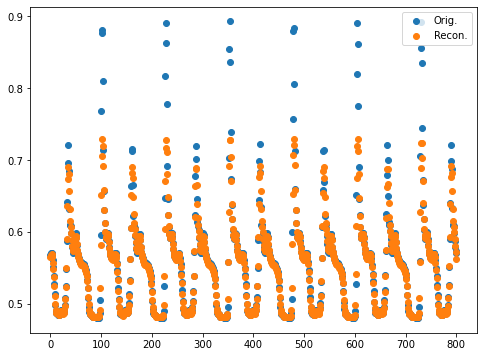

In [29]:


param = 5
Node_No = 10


x_axis1 = np.linspace(1,Lv1_latent_dim,Lv1_latent_dim)
for_decoder = np.reshape(latent_vectors, [-1, Lv1_latent_dim])
print(for_decoder.shape)

for_decoder1 = np.zeros([1, Lv1_latent_dim])
for_decoder1[:] = for_decoder[param,:]    # First param
print(for_decoder1.shape)
for_decoder2 = np.reshape(for_decoder1, [-1, Lv1_latent_dim])

EX,_ = Decoder(for_decoder1)


x_axis10=np.linspace(0,num_time,num_time)
plt.scatter(x_axis10, Lv1_input[param,:,Node_No],label ='Orig.')
plt.scatter(x_axis10, EX[0,:,Node_No],label ='Recon.')
plt.legend()

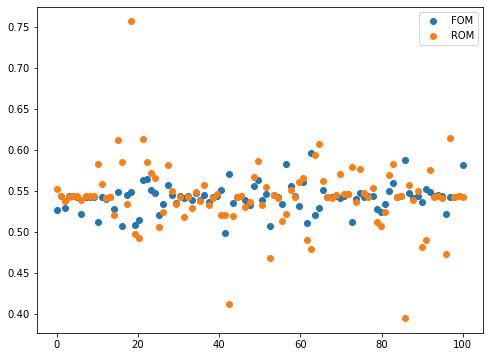

In [26]:
x_axis11=np.linspace(0,num_node,num_node)
#plt.scatter(x_axis, EX[0,0,:,0], label = 'ROM1')
plt.scatter(x_axis11, Lv1_input[0,0,:], label = 'FOM')
plt.scatter(x_axis11, EX[0,0,:], label = 'ROM')
plt.legend()

(1, 256)


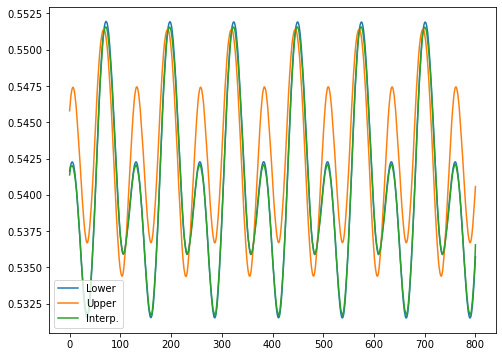

In [27]:
for_decoder_lower = np.zeros([1, Lv1_latent_dim])
for_decoder_upper = np.zeros([1, Lv1_latent_dim])
for_decoder_lower[:] = for_decoder[interp_lower,:]    # First param
for_decoder_upper[:] = for_decoder[interp_upper,:]    # First param
print(for_decoder1.shape)
#for_decoder : saved latent vectors
for_decoder1 = (for_decoder_lower+for_decoder_upper)/2

EX,_ = Decoder(for_decoder1)


plt.plot(x_axis10, Lv1_input[interp_lower,:,Node_No],label ='Lower')
plt.plot(x_axis10, Lv1_input[interp_upper,:,Node_No],label ='Upper')
plt.plot(x_axis10, EX[0,:,Node_No],label ='Interp.')
plt.legend()
#interpolated_latent = 

# Output latent vectors to file,

In [28]:
# Save latent vectors for each parameter...

for i in range(num_param):
    filename3 = 'latent_vectors_Lv1/latent_vector_p-s%d' %(i+1)
    np.savetxt(filename3, Lv1_latent[i,:,:], fmt = '%f')

NameError: name 'Lv1_latent' is not defined

# Move on to TVAE

Now as level 1, SVAE is complete, perform TVAE. Then, with the latent vector from TVAE, interpolate the latent vectors (which is with respect to the parameters). The latent vectors are interpolated and run decoder to gather interpolated latent vector for Lv 1, SVAE.

With the interpolated latent vector for Lv 1, SVAE, run it through the decoder of SVAE.

With the decoder of Lv 1, the interpolated flow field is constructed.

In [ ]:
pause;